In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import hvplot.xarray
import hvplot.pandas
# import netCDF4
import geopandas as gpd
# from geopandas import GeoDataFrame
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import glob
import os
from bokeh.models.formatters import DatetimeTickFormatter

In [24]:
# import warnings
# warnings.filterwarnings("ignore")

In [25]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

In [26]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [27]:
proj=ccrs.PlateCarree()

## AmeriFlux

In [28]:
# Import site metadata csv
ameriflux_meta = pd.read_csv('AmeriFlux-site-search-results-202410071335.tsv', sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

In [29]:
# Example sites of varying geography
site_list = ['US-A32', 'US-Bar', 'US-RGB']

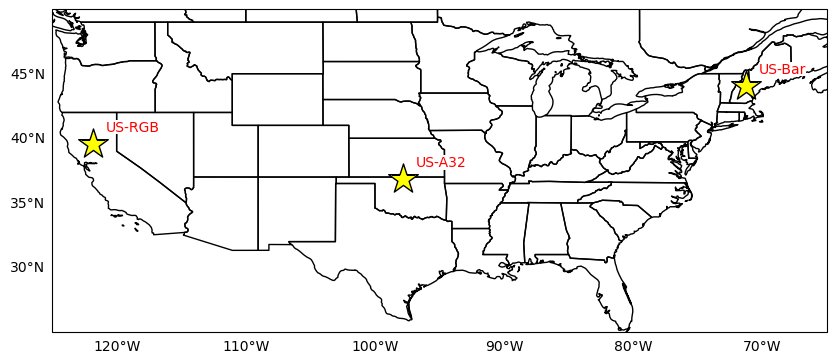

In [30]:
# Plot sites
# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(10,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)

for site_ID in site_list:
    site_sel_meta = fluxnet_simple.loc[fluxnet_simple['Site ID'] == site_ID]
    site_lat, site_lon = site_sel_meta['Latitude (degrees)'].values, site_sel_meta['Longitude (degrees)'].values
    
    ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3)
    ax.annotate(site_ID, (site_lon + 1,site_lat+1),
                color='red',
                bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                         )
                         
               )
    

# ax.legend(loc='lower left')
gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

# Plots

In [31]:
%%time
# Site 1
## Fluxnet Data 
# Import selected site half-hourly data (HH) Subset data
site_ID = site_list[0]
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + create datetime index
fluxnet_sel_simple = fluxnet_sel[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF']]
fluxnet_sel_simple .index = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
fluxnet_sel_simple.index.names = ['time']

# Convert and resample
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3

# resample to 3-hourly per MiCASA
fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean().to_xarray()

fluxnet_sel_final.assign_attrs(
    units="kg m-2 s-1", expressed_as='carbon')

formatter = DatetimeTickFormatter(months='%b %Y')
fluxnet_sel_final.hvplot(
    kind='line',
    groupby=['time.year', 'time.month'],
    xformatter=formatter,
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}'
    
)


## MiCASA
# Create a list of unique dates from the site
time = fluxnet_sel_final.time.to_index()
dates_unique = list({dt.date() for dt in time})
dates_unique.sort()

# loop over dates
data_path = 'micasa-data/daily-0.1deg-final/holding/3hrly/'
path_list = []

for date in dates_unique[:500]: #only partial load for speed
# for date in dates_unique:
    f_year = str(date.year)
    f_month = f"{date.month:02}"
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
    path_list.append(filepath)

ds = xr.open_mfdataset(path_list)['NEE']

# Select grid closest to selected site
ds_subset = ds.sel(lon=site_lon, lat=site_lat, method='nearest')
# ds_subset.hvplot(
#     kind='line',
#     groupby=['time.year', 'time.month'],
#     xformatter=formatter,
#     ylabel = 'NEE (kg C m-2 s-1)',
#     title = f'{site_ID}')
    

# Combine datasets and plot
combined = xr.merge([ds_subset,fluxnet_sel_final])
combined = combined.rename({'NEE': 'MiCASA', 'NEE_VUT_REF': 'FluxNet'})

formatter = DatetimeTickFormatter(months='%b %Y')

combined.hvplot(
    kind='line',
    groupby=['time.year', 'time.month'],
    xformatter=formatter,
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}'
    
)

CPU times: user 30.2 s, sys: 5.04 s, total: 35.2 s
Wall time: 5min 41s


:DynamicMap   [time.year,time.month]
   :NdOverlay   [Variable]
      :Curve   [time]   (value)

In [32]:
%%time
# Site 2
## Fluxnet Data 
# Import selected site half-hourly data (HH) Subset data
site_ID = site_list[1]
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + create datetime index
fluxnet_sel_simple = fluxnet_sel[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF']]
fluxnet_sel_simple .index = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
fluxnet_sel_simple.index.names = ['time']

# Convert and resample
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3

# resample to 3-hourly per MiCASA
fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean().to_xarray()

fluxnet_sel_final.assign_attrs(
    units="kg m-2 s-1", expressed_as='carbon')

fluxnet_sel_final.hvplot(
    kind='line',
    groupby=['time.year', 'time.month'],
    xformatter=formatter,
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}'
    
)
fluxnet_sel_final

CPU times: user 2.37 s, sys: 167 ms, total: 2.54 s
Wall time: 2.59 s


<xarray.DataArray 'NEE_VUT_REF' (time: 52600)> Size: 421kB
array([ 3.04356539e-09,  1.28485322e-09,  2.31221164e-09, ...,
       -8.91924652e-09,  4.09874277e-08,  5.31102617e-08])
Coordinates:
  * time     (time) datetime64[ns] 421kB 2004-01-01 ... 2021-12-31T21:00:00

In [33]:
%%time
## MiCASA
# Create a list of unique dates from the site
time = fluxnet_sel_final.time.to_index()
dates_unique = list({dt.date() for dt in time})
dates_unique.sort()

# loop over dates
data_path = 'micasa-data/daily-0.1deg-final/holding/3hrly/'
path_list = []

for date in dates_unique[:200]: #only partial load for speed
# for date in dates_unique:
    f_year = str(date.year)
    f_month = f"{date.month:02}"
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
    path_list.append(filepath)

ds = xr.open_mfdataset(path_list)['NEE']

# Select grid closest to selected site
ds_subset = ds.sel(lon=site_lon, lat=site_lat, method='nearest')

# Combine datasets and plot
combined = xr.merge([ds_subset,fluxnet_sel_final])
combined = combined.rename({'NEE': 'MiCASA', 'NEE_VUT_REF': 'FluxNet'})

formatter = DatetimeTickFormatter(months='%b %Y')

combined.hvplot(
    kind='line',
    groupby=['time.year', 'time.month'],
    xformatter=formatter,
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}'
    
)

KeyboardInterrupt: 